In [46]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [1]:
# Try a more targeted postprocessing
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [39]:
class Experiment:
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022a"
    sun_base_dir="/opt2/sfb_ocean/suntans/runs"

    def __init__(self):
        self.ptm_run_patt=os.path.join(self.ptm_base_dir,"chunk??","20??????")
    def run_paths(self):
        runs=glob.glob(self.ptm_run_patt)
        runs.sort()
        return runs
    def runs(self,criteria=None):
        result=[Run(path=p,experiment=self) 
                for p in self.run_paths()]
        if criteria is not None:
            result=[r for r in result if r.satisfies(criteria)]
        print("Narrowed to %d runs"%(len(result)))
        return result
    def runs_map_reduce(self,
                        map_func=lambda r: r,
                        reduce_func=lambda values: values,
                        criteria=None):
        return reduce_func([map_func(r) 
                            for r in utils.progress(self.runs(criteria=criteria),
                                                    msg="Runs %s")])
    def all_group_names(self):
        def mf(r):
            return r.group_names()
        def rf(lol):
            return [x for l in lol for x in l]
        return self.runs_map_reduce(map_func=mf,reduce_func=rf)
    def all_groups(self):
        def mf(r):
            grps=r.groups()
            return grps
        def rf(lol):    
            return [x for l in lol for x in l]
        return self.runs_map_reduce(map_func=mf,reduce_func=rf)
    def query_particles(self,criteria):
        """
        criteria: t_min, t_max ~ np.datetime64
          behaviors: list of strings, 'down5000','none',etc.
          sources: list of strings, shortened names.
        returns dataframe.
        """
        def query_run(run):
            print(f"query_particles.query_run({run.path})")
            return run.query_particles(criteria)
        return self.runs_map_reduce(criteria=criteria,
                                    map_func=query_run,
                                    reduce_func=lambda values: pd.concat(values))
class Run:
    experiment=None
    path=None
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
    def group_names(self):
        bin_out_fns=glob.glob(os.path.join(self.path,"*_bin.out"))
        group_names=[os.path.basename(p).replace('_bin.out','') for p in bin_out_fns]
        return group_names
    @memoize.imemoize()
    def groups(self):
        return [Group(run=self,name=name) for name in self.group_names()]
    def satisfies(self,criteria):
        if 't_min' in criteria and self.t_max()<criteria['t_min']:
            return False
        if 't_max' in criteria and self.t_min()>criteria['t_max']:
            return False
        return True
    @memoize.imemoize()
    def ptm_config(self):
        return ptm_config.PtmConfig.load(self.path)
    def t_max(self):
        "Maximum time of particle outputs for the run."
        return self.ptm_config().end_time
    def t_min(self):
        "Minimum time of particle outputs."
        # relies on knowing that all groups follow the same start/end 
        # within a run
        return self.groups()[0].t_min()
    def query_particles(self,criteria):
        results=[g.query_particles(criteria)
                 for g in utils.progress(self.groups(),msg="  Groups %s")
                 if g.satisfies(criteria)]
        if results:
            df=pd.concat(results)
            df['run']=self.path
            return df
        else:
            return pd.DataFrame()
     
class Group:
    run=None
    name=None
    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        m=re.match(r'(.*)_((up|down|none)\d*)_rel(\d+)',self.name)
        self.source,self.behavior,self.release_date=m.group(1),m.group(2),m.group(4)
    def satisfies(self,criteria):
        if 'sources' in criteria and self.source not in criteria.sources:
            return False
        if 't_min' in criteria and self.t_max() < criteria['t_min']:
            return False
        if 't_max' in criteria and self.t_min() > criteria['t_max']:
            return False
        if 'behaviors' in criteria and self.behavior not in criteria.behaviors:
            return False
        return True
    @memoize.imemoize()
    def t_max(self):
        return self.run.t_max()
    @memoize.imemoize()
    def t_min(self):
        release_log_fn=os.path.join(self.run.path,self.name+".release_log")
        with open(release_log_fn,'rt') as fp:
            rel_date,rel_time=fp.readline().strip().split()[-2:]
        return np.datetime64(rel_date+" "+rel_time)
    @memoize.imemoize()
    def ptm_bin(self):
        return ptm_tools.PtmBin(fn=os.path.join(self.run.path,self.name+"_bin.out"))
    @memoize.imemoize()
    def release_log(self):
        df_rel=ptm_tools.release_log_dataframe(fn=os.path.join(self.run.path,self.name+".release_log"))
        # release has id and gid. So far they are always the same
        # Trust, but verify.
        assert np.all(df_rel['id'].values==df_rel['gid'].values),"Invariant check"
        return df_rel
    
    def query_particles(self,criteria):
        # Could be faster by using index instead of bin file
        pbf=self.ptm_bin()
        times=np.array( [utils.to_dt64(t) for t in pbf.time] )
        sel=np.ones(len(times),np.bool8)
        if 't_min' in criteria:
            sel=sel&(times>=criteria['t_min'])
        if 't_max' in criteria:
            sel=sel&(times<=criteria['t_max'])

        all_particles=[]
        for ts in np.nonzero(sel)[0]:
            datenum,particles=pbf.read_timestep(ts)
            t=utils.to_dt64(datenum)
            #particles=self.filter_particles(particle,criteria)
            #df=pd.DataFrame(particles) # Can't deal with vectors
            df=pd.DataFrame()
            df['id']=particles['id']
            df['x0']=particles['x'][:,0]
            df['x1']=particles['x'][:,1]
            df['x2']=particles['x'][:,2]
            df['active']=particles['active']
            df['time']=t
            all_particles.append(df)
        if len(all_particles):
            df=pd.concat(all_particles)
            df['group']=self.name
            
            # Assign release times
            # If this is slow, could verify that release_log index 
            # is dense, and do this in numpy
            df_rel=self.release_log().set_index('id') # id vs gid?
            rel_times=df_rel.loc[ df['id'].values,'date_time']
            df['rel_time']=rel_times.values
            
            return df
        else:
            return pd.DataFrame()

                
experiment=Experiment()
runs=experiment.runs()
print(f"{len(runs)} runs found")
groups=experiment.all_groups()
print(f"{len(groups)} groups total")


Narrowed to 124 runs
124 runs found
Narrowed to 124 runs
10633 groups total


In [40]:
%%time
criteria=dict(t_min=np.datetime64("2017-07-01 00:00"),
              t_max=np.datetime64("2017-07-01 04:00"),
              behavior='up5000')

particles=experiment.query_particles(criteria=criteria)
print(f"Found {len(particles)} particles")
# Promising:
# Can query 1M particles in 4s. That's 4h of one run.
# In this case, 8 runs satisfy the time slice.
# Cold start, queries 4.5M particles over 8 runs in 70s.
# Warm start, 28s.

Narrowed to 8 runs
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20170620)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20170630)


INFO:utils:Runs 2/8


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk01/20170620)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk01/20170630)


INFO:utils:Runs 4/8


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk02/20170620)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk02/20170630)


INFO:utils:Runs 6/8


query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20170620)
query_particles.query_run(/opt2/sfb_ocean/ptm/all_source_022a/chunk03/20170630)
Found 4571595 particles
CPU times: user 27.1 s, sys: 795 ms, total: 27.9 s
Wall time: 27.9 s


In [53]:
particles.head()

,id,x0,x1,x2,active,time,group,rel_time,run
0,1,568222.872843,4.167250e+06,-7.656522,1,2017-07-01,San_Lorenzo_C_down50000_rel20170620,2017-06-20,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...
1,2,572658.288323,4.168268e+06,-6.561929,1,2017-07-01,San_Lorenzo_C_down50000_rel20170620,2017-06-20,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...
2,3,566678.193566,4.169198e+06,-9.201712,1,2017-07-01,San_Lorenzo_C_down50000_rel20170620,2017-06-20,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...
3,4,567325.269727,4.169133e+06,-7.707711,1,2017-07-01,San_Lorenzo_C_down50000_rel20170620,2017-06-20,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...
4,5,571845.056607,4.168952e+06,-6.382395,1,2017-07-01,San_Lorenzo_C_down50000_rel20170620,2017-06-20,/opt2/sfb_ocean/ptm/all_source_022a/chunk00/20...


In [44]:
g=unstructured_grid.UnstructuredGrid.read_ugrid("/home/rusty/src/sfb_ocean/"
                                                "suntans/grid-merge-suisun/spliced-bathy.nc")

In [54]:
age=(particles['time']-particles['rel_time'])/np.timedelta64(1,'s')

<IPython.core.display.Javascript object>


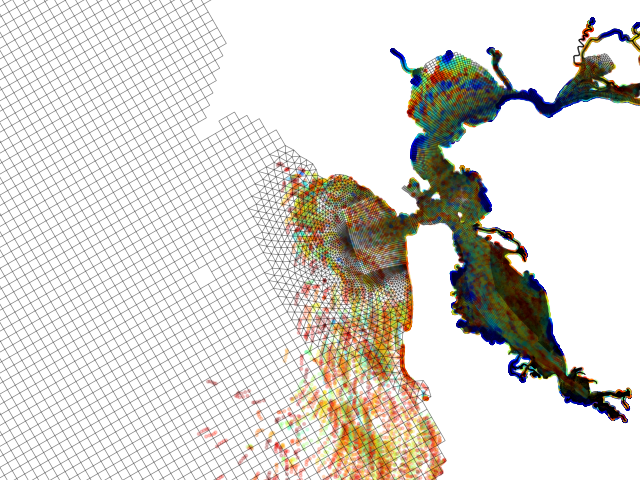

In [57]:
fig,ax=plt.subplots(1,1)
g.plot_edges(color='k',lw=0.5,alpha=0.5,ax=ax)
ax.set_position([0,0,1,1])
ax.axis('off')
ax.axis('tight')
ax.axis('equal')

sel=slice(None,None,20)
x=particles['x0']
y=particles['x1']
ax.scatter(x[sel],y[sel],4,age[sel],alpha=0.2,cmap='jet')

Status
--

Reasonable performance reading data single-threaded.

Next steps:

1. Have Experiment or Run filter on z and/or add relative z position
   to results.
2. Have Group (or maybe a Source class) add weighting by forcing data.
3. How hard would it be to parallelize at some level?  Don't do this too
   early, but take a look in case it's easy.
4. Recreate some of the figures from before, including on-grid smoothing.
5. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.